In [1]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
import utils
from functools import partial
from utils import KernelFunction, KernelEnvironment, log_likelihood_reward
from utils import plot_kernel_function, compare_kernels
from gflownet import GFlowNet 

In [2]:
import torch.nn.functional as F
from torch.distributions import Categorical
import torch

In [3]:
from utils import ForwardPolicy, BackwardPolicy
import random

In [4]:
def create_env(batch_size=64):
    return KernelEnvironment(
    batch_size=batch_size,
    max_trajectory_length=MAX_LEN,
    log_reward=log_reward_fn
)

def create_env(batch_size=64):
    return KernelEnvironment(
    batch_size=batch_size,
    max_trajectory_length=MAX_LEN,
    log_reward=log_reward_fn
)

In [5]:
def randomize_hyperparameters(kernel: KernelFunction):
    """
    Recursively traverses a KernelFunction object and randomly modifies the
    hyperparameters of its base components in a reasonable range.
    
    Args:
        kernel (KernelFunction): The kernel object to modify in-place.
    """
    # Base case: If this is a base kernel (like RBF, Linear), modify its params.
    # A base kernel has no children.
    if not kernel.children:
        if kernel.hyperparams:
            print(f"  -> Randomizing '{kernel.name}' params...")
            for param, value in kernel.hyperparams.items():
                # Define a scaling factor to adjust the parameter.
                # e.g., random.uniform(0.5, 1.5) will change the value
                # by -50% to +50% of its original value.
                scale_factor = random.uniform(0.5, 1.5)
                new_value = value * scale_factor
                
                # Update the hyperparameter in the dictionary, rounding for neatness
                kernel.hyperparams[param] = round(new_value, 3)

    # Recursive step: If this is a composite kernel (Sum, Product),
    # call this function on each of its children.
    else:
        for child in kernel.children:
            randomize_hyperparameters(child)

def create_random_kernel():
    """
    Creates a random kernel function.
    """
    # Create a series of actions from a uniform distribution
    env = KernelEnvironment(
        batch_size=1,
        max_trajectory_length=4,
        log_reward=log_likelihood_reward
    )
    n = env.action_space_size  
    logits = torch.ones(n) 
   

    for i in range(4):
        if i == 0:
            #prevent the first action from being a stop (-1)
            logits[-1] = -torch.inf
            dist = Categorical(logits=logits)
            actions = dist.sample((1,))  # Creates a 1D tensor of shape [1]
        else:
            logits[-1] = 1
            dist = Categorical(logits=logits)
            actions = dist.sample((1,)) # Creates a 1D tensor of shape [1]

        env.apply(actions)
    
    KFn = env.state[0]
    randomize_hyperparameters(KFn)
    
    return KFn


  -> Randomizing 'Constant' params...
  -> Randomizing 'Constant' params...
  -> Randomizing 'RBF' params...
True Kernel: ((Constant({'variance': 1.343}) * Constant({'variance': 0.792})) + RBF({'lengthscale': 1.0, 'variance': 0.527})) Log Marginal Likelihood: 49.044680206638176


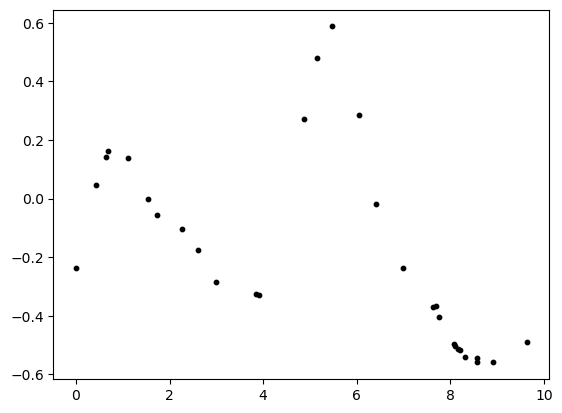

In [6]:
ll = -1
while ll < 0:
    true_kernel = create_random_kernel()
    X, Y, true_kernel_str = utils.generate_gp_data(true_kernel, input_dim=1, n_points=30, noise_var=1e-4)
    X_test, Y_test, _ = utils.generate_gp_data(true_kernel, input_dim=1, n_points=50, noise_var=1e-4)
    ll = utils.evaluate_likelihood(true_kernel, X, Y, runtime=False)

print("True Kernel:", true_kernel_str, "Log Marginal Likelihood:", utils.evaluate_likelihood(true_kernel, X, Y, runtime=False))

plt.scatter(X, Y, color='black', s=10, label='Data Points')

In [7]:
candidate_kernel = create_random_kernel()
print("True Kernel:", candidate_kernel, "Log Marginal Likelihood:", utils.evaluate_likelihood(candidate_kernel, X, Y, runtime=False))

  -> Randomizing 'Periodic' params...
  -> Randomizing 'Constant' params...
  -> Randomizing 'Periodic' params...
True Kernel: ((Periodic({'period': 0.794, 'variance': 0.849, 'lengthscale': 1.335}) * Constant({'variance': 0.884})) + Periodic({'period': 1.165, 'variance': 0.914, 'lengthscale': 1.009})) Log Marginal Likelihood: 52.031505304162955


In [8]:
from utils import train

epochs = 100
BATCH_SIZE = 64
MAX_LEN = 4
lr = 1e-3

log_reward_fn = partial(utils.log_likelihood_reward, X, Y)
env = create_env()

forward_model = ForwardPolicy(input_dim=MAX_LEN, output_dim=env.action_space_size, epsilon=0.5)
backward_model = BackwardPolicy()
criterion = 'db'

In [9]:
gflownet = GFlowNet(
    forward_flow=forward_model, 
    backward_flow=backward_model, 
    criterion=criterion 
)


gflownet, losses = train(
    gflownet=gflownet,
    create_env=create_env,
    epochs=epochs,
    batch_size=BATCH_SIZE,
    lr=lr,
    min_eps=1e-2,
    clamp_g= 10,
    use_scheduler=True
)

100%|██████████| 100/100 [00:46<00:00,  2.16it/s, loss=34.3]


In [10]:
len(utils._likelihood_cache)

294

In [17]:
# --- Sampling from the Trained GFlowNet ---
print("\n Sampling 25 kernels from the trained model...")
eval_env = KernelEnvironment(
    batch_size=25,
    max_trajectory_length=MAX_LEN,
    log_reward=log_reward_fn
)

gflownet.eval()
final_batch_ll = gflownet.sample(eval_env)

# Expect to see kernels with high log likelihood
for i, kernel in enumerate(final_batch_ll.state):
    print(f"Sample {i+1}: {kernel}, Reward: {1 / np.log(1 + np.exp(-0.05 * (utils.evaluate_likelihood(kernel, X, Y))))}, Log Likelihood: {utils.evaluate_likelihood(kernel, X_test, Y_test):.4f}")


 Sampling 25 kernels from the trained model...
Sample 1: ((Constant({'variance': 1.0}) * Linear({'variances': 1.0})) + RBF({'lengthscale': 1.0, 'variance': 1.0})), Reward: 12.10134561789539, Log Likelihood: 49.0343
Sample 2: Periodic({'period': 1.0, 'variance': 1.0, 'lengthscale': 1.0}), Reward: 1.0141373317103657, Log Likelihood: -10.3836
Sample 3: ((Constant({'variance': 1.0}) * Linear({'variances': 1.0})) * Linear({'variances': 1.0})), Reward: 1.278476280774937, Log Likelihood: -3.4157
Sample 4: ((Periodic({'period': 1.0, 'variance': 1.0, 'lengthscale': 1.0}) * Constant({'variance': 1.0})) + Linear({'variances': 1.0})), Reward: 1.1769024172181601, Log Likelihood: -5.8372
Sample 5: ((Constant({'variance': 1.0}) * Periodic({'period': 1.0, 'variance': 1.0, 'lengthscale': 1.0})) * Periodic({'period': 1.0, 'variance': 1.0, 'lengthscale': 1.0})), Reward: 1.0156193705518115, Log Likelihood: -10.3377
Sample 6: ((RBF({'lengthscale': 1.0, 'variance': 1.0}) * Linear({'variances': 1.0})) + Lin

In [12]:
eval_env = KernelEnvironment(
    batch_size=1000,
    max_trajectory_length=MAX_LEN,
    log_reward=log_reward_fn
)

gflownet.eval()
final_batch_ll = gflownet.sample(eval_env)


#Count different kernels AKA numbeer of modes
kernel_counts = {}
for kernel in final_batch_ll.state:
    #only add the kernel if it is not already in the dictionary
    kernel_str = str(kernel)
    if kernel_str not in kernel_counts:
        kernel_counts[kernel_str] = 1
    else:
        kernel_counts[kernel_str] += 1

print(f"Total number of unique kernels sampled: {len(kernel_counts)}")



Total number of unique kernels sampled: 256


In [13]:
from evaluation import calculate_l1_distance

In [14]:
l1 = calculate_l1_distance(gflownet.forward_flow , KernelEnvironment, 4, X, Y)

In [15]:
l1

0.9778946999151688

In [16]:
print(f"Total reward calls: {len(utils._likelihood_cache)}")
#utils._likelihood_cache = {}  # Clear the cache after sampling

Total reward calls: 294
